In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/employee-churn/WA_Fn-UseC_-HR-Employee-Attrition.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("/kaggle/input/employee-churn/WA_Fn-UseC_-HR-Employee-Attrition.csv")

drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'] 
df.drop(columns=drop_cols, inplace=True, errors='ignore')

for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':  # categorical
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:  # numerical
            df[col].fillna(df[col].median(), inplace=True)


In [4]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

df = pd.get_dummies(df, drop_first=True)
skewness = df.skew().sort_values(ascending=False)
skewed_cols = skewness[abs(skewness) > 1].index  
for col in skewed_cols:
    if df[col].min() > 0: 
        df[col] = np.log1p(df[col])

In [5]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data prep complete:")
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Data prep complete:
Train shape: (1176, 44)
Test shape: (294, 44)


In [6]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


from sklearn.metrics import classification_report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

target_counts = y.value_counts()
print("\nOriginal Target Distribution:")
print(target_counts)
print(f"Imbalance ratio (Yes/No): {target_counts[1]/target_counts[0]:.2f}")

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       247
           1       0.36      0.68      0.47        47

    accuracy                           0.76       294
   macro avg       0.64      0.73      0.66       294
weighted avg       0.84      0.76      0.78       294


Original Target Distribution:
Attrition
0    1233
1     237
Name: count, dtype: int64
Imbalance ratio (Yes/No): 0.19


In [7]:
import xgboost as xgb
from sklearn.metrics import classification_report

scale_pos_weight = 1233 / 237 

xgb_weighted = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = xgb_weighted.predict(X_test_scaled)

print("Weighted XGBoost Classification Report on Test Set:")
print(classification_report(y_test, y_pred_weighted))

Weighted XGBoost Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.50      0.32      0.39        47

    accuracy                           0.84       294
   macro avg       0.69      0.63      0.65       294
weighted avg       0.82      0.84      0.83       294



In [11]:
y_probs = xgb_weighted.predict_proba(X_test_scaled)[:, 1]

threshold = 0.3 
y_final_pred = (y_probs > threshold).astype(int)
from sklearn.metrics import classification_report
print(f"Classification Report with threshold={threshold}:")
print(classification_report(y_test, y_final_pred))


Classification Report with threshold=0.3:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       247
           1       0.50      0.43      0.46        47

    accuracy                           0.84       294
   macro avg       0.70      0.67      0.68       294
weighted avg       0.83      0.84      0.83       294



Top 5 Features Influencing Attrition:
                      Feature  Importance
37  JobRole_Research Director    0.076270
43               OverTime_Yes    0.053321
26           Department_Sales    0.039844
7                    JobLevel    0.039573
15           StockOptionLevel    0.039060


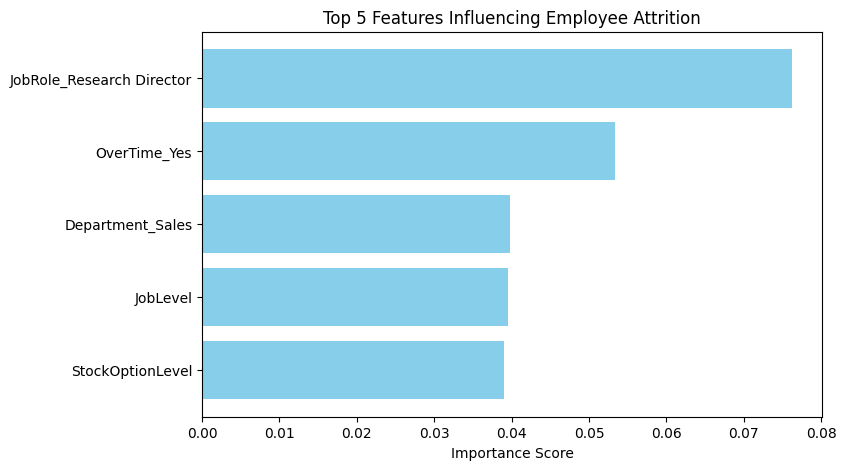

In [10]:

import matplotlib.pyplot as plt
importances = xgb_weighted.feature_importances_

features = X_train.columns 
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)


top_5_features = feat_imp_df.head(5)
print("Top 5 Features Influencing Attrition:")
print(top_5_features)

plt.figure(figsize=(8,5))
plt.barh(top_5_features['Feature'][::-1], top_5_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 5 Features Influencing Employee Attrition')
plt.show()
